In [ ]:
!pip install yfinance

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from datetime import datetime
import yfinance as yf
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [ ]:
df = yf.download("QQQ AAPL MSFT AMZN FB GOOGL NVDA TSLA PYPL ADBE CSCO NFLX INTC PEP AVGO COST TXN QCOM HON SBUX AMD AMGN AMAT MELI GILD ADP ZM JD ADI EBAY BIIB ROST WBA BIDU PCAR NTES VRSN TCOM", start="2019-01-01", group_by="ticker")
df = df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
df = df.sort_values(by=['Ticker', 'Date'])
df_backup = df.reset_index().copy()
df['Adj Close'] = df['Adj Close'] / df['Adj Close'].shift(1) - 1
df = df[df.Ticker == df.Ticker.shift(1)].copy()
df = df.iloc[:,0:2].pivot(columns='Ticker')
df.columns = df.columns.droplevel()
df = df.reset_index()
df['aniomes'] = df.Date.dt.strftime('%Y%m')

[*********************100%***********************]  38 of 38 completed


## Ejemplo básico

In [ ]:
df

Ticker,Date,AAPL,ADBE,ADI,ADP,AMAT,AMD,AMGN,AMZN,AVGO,BIDU,BIIB,COST,CSCO,EBAY,FB,GILD,GOOGL,HON,INTC,JD,MELI,MSFT,NFLX,NTES,NVDA,PCAR,PEP,PYPL,QCOM,QQQ,ROST,SBUX,TCOM,TSLA,TXN,VRSN,WBA,ZM,aniomes
0,2019-01-03,-0.099608,-0.039498,-0.060405,-0.030198,-0.057945,-0.094530,-0.015216,-0.025242,-0.088951,-0.046471,0.007581,-0.021196,-0.036368,-0.018371,-0.029039,0.028531,-0.027696,-0.013351,-0.055013,-0.043253,-0.004765,-0.036788,0.013226,-0.038478,-0.060417,-0.023159,-0.009334,-0.042682,-0.029617,-0.032671,-0.008355,-0.043377,-0.022834,-0.031472,-0.058973,-0.034989,-0.010435,NaN,201901
1,2019-01-04,0.042689,0.048632,0.024279,0.039854,0.068484,0.114370,0.034184,0.050064,0.009829,0.040333,0.036905,0.029039,0.045045,0.022952,0.047138,0.045977,0.051294,0.034981,0.061362,0.094349,0.063185,0.046509,0.097234,0.040063,0.064068,0.044409,0.020506,0.050920,0.016158,0.042785,0.027203,0.033155,0.058976,0.057697,0.045230,0.044744,0.033269,NaN,201901
2,2019-01-07,-0.002226,0.013573,0.006289,-0.005410,0.017804,0.082632,0.013457,0.034353,0.020366,0.010252,0.012785,0.003685,0.006757,0.017259,0.000725,0.004542,-0.001994,0.005571,0.004659,0.022003,0.043161,0.001275,0.059717,0.042394,0.052941,-0.001186,-0.008599,0.007650,-0.002827,0.011905,0.042067,0.000000,0.022067,0.054361,0.017223,0.016312,0.005749,NaN,201901
3,2019-01-08,0.019063,0.014918,0.024396,0.005899,-0.040525,0.008751,0.012824,0.016612,-0.008026,0.004920,0.006328,0.007488,0.008100,0.017984,0.032452,-0.006856,0.008783,-0.002068,0.006324,0.008348,-0.001368,0.007251,0.015634,0.012193,-0.024895,0.009667,0.009587,0.020361,-0.008682,0.009046,0.029349,0.000786,0.010281,0.001164,-0.001270,0.036460,0.020009,NaN,201901
4,2019-01-09,0.016982,0.011819,0.025340,0.000914,0.042236,-0.026988,-0.001196,0.001714,0.043250,0.019829,0.006750,0.006473,-0.005509,0.009667,0.011927,-0.002203,-0.003427,0.004663,0.005656,0.032244,0.034917,0.014300,-0.000968,0.066128,0.019667,-0.015118,-0.027944,0.009583,0.011796,0.008150,-0.013109,0.004087,0.023745,0.009483,0.019708,-0.008157,0.012050,NaN,201901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,2021-12-23,0.003644,0.010000,0.002148,0.018433,0.020811,0.015707,0.010202,0.000184,0.014652,0.004601,0.003966,0.001274,0.012189,0.014858,0.014495,0.000690,0.003425,0.016746,0.006671,-0.069153,0.028332,0.004472,-0.000244,0.002254,0.008163,0.008189,-0.001118,0.001722,0.007498,0.007539,0.010364,0.005638,0.039773,0.057619,0.002514,0.011794,0.001389,-0.007663,202112
751,2021-12-27,0.022975,0.014150,0.016275,0.017727,0.046498,0.056247,0.006167,-0.008178,0.014260,-0.002428,-0.005182,0.023802,0.018304,0.011866,0.032633,0.005381,0.006738,0.005896,0.012278,-0.013693,0.028811,0.023186,-0.001580,-0.004088,0.044028,0.010006,0.009954,0.000000,0.019645,0.016527,0.020062,0.016463,-0.009248,0.025248,0.023693,0.009454,0.004952,-0.021967,202112
752,2021-12-28,-0.005767,-0.014402,-0.006212,-0.000893,-0.018928,-0.007839,0.002665,0.005844,-0.007831,-0.020102,0.007686,0.002076,0.001734,0.006397,0.000116,0.001372,-0.008245,0.003003,-0.003466,-0.027175,0.013217,-0.003504,-0.003931,-0.002976,-0.020133,0.012820,0.005190,-0.009947,-0.008104,-0.004635,-0.001869,0.011819,-0.011879,-0.005000,-0.003857,0.001627,0.013799,-0.019580,202112
753,2021-12-29,0.000502,-0.000123,0.006537,0.007884,0.008394,-0.031929,0.008106,-0.008555,0.005396,-0.032510,0.094580,0.005543,0.006768,0.005751,-0.009474,0.009182,-0.000218,0.002318,0.001352,-0.003644,0.005531,0.002051,-0.000278,-0.019557,-0.010586,0.008400,0.003539,-0.000684,0.007467,-0.000149,0.010253,0.007009,-0.018033,-0.002095,-0.001518,0.013946,0.015944,-0.010666,202112


In [ ]:
training_months = ['202104', '202105', '202106']
testing_months = ['202107']
df_train = df[df.aniomes.isin(training_months)]
df_test = df[df.aniomes.isin(testing_months)]
print(df_train, df_test)

Ticker       Date      AAPL      ADBE  ...       WBA        ZM  aniomes
565    2021-04-01  0.006959  0.016766  ... -0.002732  0.015376   202104
566    2021-04-05  0.023577  0.017131  ...  0.037443 -0.006958   202104
567    2021-04-06  0.002462 -0.000570  ... -0.019366  0.017996   202104
568    2021-04-07  0.013390  0.004213  ... -0.002154 -0.020346   202104
569    2021-04-08  0.019234  0.013032  ... -0.014214  0.025381   202104
..            ...       ...       ...  ...       ...       ...      ...
623    2021-06-24 -0.002169  0.007018  ...  0.000384 -0.009339   202106
624    2021-06-25 -0.002249  0.002421  ...  0.001152 -0.002491   202106
625    2021-06-28  0.012546  0.015768  ...  0.000959  0.044004   202106
626    2021-06-29  0.011500  0.003312  ... -0.004214  0.015095   202106
627    2021-06-30  0.004621 -0.008650  ...  0.011925 -0.019507   202106

[63 rows x 40 columns] Ticker       Date      AAPL      ADBE  ...       WBA        ZM  aniomes
628    2021-07-01  0.002263 -0.001554  .


 Activos en la cartera 
   Activo  Coeficiente
0    AAPL     0.070826
1    ADBE     0.013194
4    AMAT     0.125523
14     FB     0.002940
16  GOOGL     0.004957
24   NVDA     0.066142
27   PYPL     0.068863
28   QCOM     0.056489
32   TSLA     0.053189
36     ZM     0.006562

 Relación entre retornos de la cartera y del QQQ 


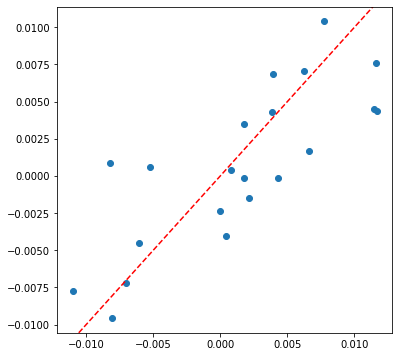


 Evolución durante el período de test 


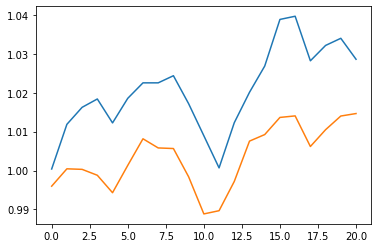

Rendimiento total real del QQQ:  1.0286
Rendimiento de la cartera que replica QQQ:  1.0147


In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

coef = 0.00003
X_train = df_train[df_train.columns.difference(['Date', 'aniomes', 'QQQ'])].dropna(axis='columns')
y_train = df_train.QQQ
lasso = Lasso(alpha=coef)
lasso.fit(X_train, y_train)
coefs = pd.DataFrame({'Activo':X_train.columns.values, 'Coeficiente':lasso.coef_})
coefs = coefs[coefs.Coeficiente != 0]
print('\n Activos en la cartera ')
print(coefs)
X_test = df_test.loc[:, df_test.columns.isin(X_train.columns)]
y_test = df_test.QQQ

X_test = df_test.loc[:, df_test.columns.isin(X_train.columns)]
y_test = df_test.QQQ

print('\n Relación entre retornos de la cartera y del QQQ ')
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test.values, lasso.predict(X_test))
add_identity(ax, color='r', ls='--')
plt.show()

reales = []
result = 1
for i in range(0, len(y_test.values)):
  result = result * (1 + y_test.values[i])
  reales.append(result)

predichos = []
result = 1
for i in range(0, len(lasso.predict(X_test))):
  result = result * (1 + lasso.predict(X_test)[i])
  predichos.append(result)

print('\n Evolución durante el período de test ')
plt.plot(reales)
plt.plot(predichos)
plt.show()
print('Rendimiento total real del QQQ: ', round(reales[-1], 4))
print('Rendimiento de la cartera que replica QQQ: ', round(predichos[-1], 4))

## Loop

In [ ]:
def determino_coeficiente(a, nro):
  model = Lasso(alpha=a)
  model.fit(X_train, y_train)
  coefs = pd.DataFrame({'Activo':X_train.columns.values, 'Coeficiente':model.coef_})
  if len(coefs[coefs.Coeficiente > 0.01]) == nro:
    return a
  elif len(coefs[coefs.Coeficiente > 0.01]) > nro:
    return determino_coeficiente(a*1.5, nro)
  elif len(coefs[coefs.Coeficiente > 0.01]) < nro:
    return determino_coeficiente(a*0.5, nro)

import numpy as np
resumen = pd.DataFrame(columns = ['Meses entrenamiento', 'Meses testeo', 'Cartera', 'Ponderaciones', 'Rendimiento de la cartera', 'Rendimiento real del QQQ'])

numero_esperado_de_activos = 10
meses_train = 12
meses_test = 3

############ EMPIEZA CÓDIGO

primero_train = 0
ultimo_train = primero_train + meses_train
ultimo_test = ultimo_train + meses_test

while ultimo_train < len(df.aniomes.unique()):

  training_months = df.aniomes.unique()[primero_train:ultimo_train]
  testing_months = df.aniomes.unique()[ultimo_train:ultimo_test]

  df_train = df[df.aniomes.isin(training_months)]
  try:
    df_test = df[df.aniomes.isin(testing_months)]
  except:
    df_test = df[df.aniomes.isin([testing_months])]

  X_train = df_train[df_train.columns.difference(['Date', 'aniomes', 'QQQ'])].dropna(axis='columns')
  y_train = df_train.QQQ
  coeficiente = determino_coeficiente(0.00001, numero_esperado_de_activos)
  lasso = Lasso(alpha=coeficiente)
  lasso.fit(X_train, y_train)
  coefs = pd.DataFrame({'Activo':X_train.columns.values, 'Coeficiente':lasso.coef_})
  coefs = coefs[coefs.Coeficiente > 0.01]

  for mes in testing_months:
    df_test_mes = df_test[df_test.aniomes == mes]
    X_test = df_test_mes.loc[:, df_test.columns.isin(X_train.columns)]
    y_test = df_test_mes.QQQ

    reales = []
    result = 1
    for i in range(0, len(y_test.values)):
      result = result * (1 + y_test.values[i])
      reales.append(result)

    predichos = []
    result = 1
    for i in range(0, len(lasso.predict(X_test))):
      result = result * (1 + lasso.predict(X_test)[i])
      predichos.append(result)

    primero_train = primero_train + 1
    ultimo_train = primero_train + meses_train
    ultimo_test = ultimo_train + meses_test

    ponderaciones = np.around(coefs.Coeficiente.values / coefs.Coeficiente.sum(), 2)
    resumen.loc[len(resumen)] = [[training_months], [mes], [coefs.Activo.values], [ponderaciones], round(predichos[-1], 4), round(reales[-1], 4)]

In [ ]:
resumen

,Meses entrenamiento,Meses testeo,Cartera,Ponderaciones,Rendimiento de la cartera,Rendimiento real del QQQ
0,"[[201901, 201902, 201903, 201904, 201905, 2019...",[202001],"[[AAPL, ADBE, AMAT, AMD, FB, GOOGL, JD, MELI, ...","[[0.24, 0.03, 0.03, 0.11, 0.07, 0.1, 0.12, 0.0...",1.0261,1.0304
1,"[[201901, 201902, 201903, 201904, 201905, 2019...",[202002],"[[AAPL, ADBE, AMAT, AMD, FB, GOOGL, JD, MELI, ...","[[0.24, 0.03, 0.03, 0.11, 0.07, 0.1, 0.12, 0.0...",1.0033,0.9394
2,"[[201901, 201902, 201903, 201904, 201905, 2019...",[202003],"[[AAPL, ADBE, AMAT, AMD, FB, GOOGL, JD, MELI, ...","[[0.24, 0.03, 0.03, 0.11, 0.07, 0.1, 0.12, 0.0...",0.9949,0.9271
3,"[[201904, 201905, 201906, 201907, 201908, 2019...",[202004],"[[AAPL, ADBE, AMAT, AMD, GOOGL, INTC, MELI, MS...","[[0.23, 0.03, 0.12, 0.02, 0.02, 0.04, 0.03, 0....",1.0814,1.1497
4,"[[201904, 201905, 201906, 201907, 201908, 2019...",[202005],"[[AAPL, ADBE, AMAT, AMD, GOOGL, INTC, MELI, MS...","[[0.23, 0.03, 0.12, 0.02, 0.02, 0.04, 0.03, 0....",1.0555,1.0660
5,"[[201904, 201905, 201906, 201907, 201908, 2019...",[202006],"[[AAPL, ADBE, AMAT, AMD, GOOGL, INTC, MELI, MS...","[[0.23, 0.03, 0.12, 0.02, 0.02, 0.04, 0.03, 0....",1.0544,1.0629
6,"[[201907, 201908, 201909, 201910, 201911, 2019...",[202007],"[[AAPL, ADBE, ADP, AMAT, AMD, INTC, MSFT, NVDA...","[[0.24, 0.03, 0.05, 0.12, 0.04, 0.05, 0.25, 0....",1.0459,1.0735
7,"[[201907, 201908, 201909, 201910, 201911, 2019...",[202008],"[[AAPL, ADBE, ADP, AMAT, AMD, INTC, MSFT, NVDA...","[[0.24, 0.03, 0.05, 0.12, 0.04, 0.05, 0.25, 0....",1.0837,1.1094
8,"[[201907, 201908, 201909, 201910, 201911, 2019...",[202009],"[[AAPL, ADBE, ADP, AMAT, AMD, INTC, MSFT, NVDA...","[[0.24, 0.03, 0.05, 0.12, 0.04, 0.05, 0.25, 0....",0.9644,0.9422
9,"[[201910, 201911, 201912, 202001, 202002, 2020...",[202010],"[[AAPL, ADBE, ADP, AMAT, FB, INTC, MSFT, NVDA,...","[[0.25, 0.11, 0.02, 0.12, 0.02, 0.03, 0.22, 0....",0.9650,0.9696


In [ ]:
abs(resumen['Rendimiento de la cartera'] - resumen['Rendimiento real del QQQ']).describe()

count    24.000000
mean      0.023221
std       0.021946
min       0.000900
25%       0.008575
50%       0.015300
75%       0.031400
max       0.076300
dtype: float64